In [68]:
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

hide_toggle()

In [69]:
%%html
<style>
.cust-table{
    display: block
}

.cust-table th {
text-align: left;
}

.cust-table td {
text-align: left;
}

.cust-table img {
border: 1px solid black;
}
</style>


<img src="./images/usgs.png" style=" padding-top: 26px; float: left"/>
<img src="./images/WaveLabLogo.png" style="float: left"/>

# Storm-Tide Water Level

To begin, we take a time series of sea pressure corrected by barometric pressure.

In [70]:
import matplotlib
from matplotlib import pyplot as plt
import numpy as np

def plot_graph(x_data, y_data, title, x_label, y_label, size, name):
    
    _, ax = plt.subplots(figsize=size)
    ax.plot(x_data,y_data)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    file_name = './images/%s.png' % name
    plt.savefig(file_name)
    return file_name
    

In [71]:
from wavelab.utilities.nc import (get_pressure, 
                                  get_air_pressure, 
                                  get_time, 
                                  get_datetimes)

sea_file = '../data/NCCAR00007_1511451_sea.csv.nc'
baro_file = '../data/NCCAR12248_9983816_air.csv.nc'

# Load all of the data
sea_pressure_data = get_pressure(sea_file)
sea_milli = get_time(sea_file)
sea_date_times = get_datetimes(sea_file)

baro_pressure_data = get_air_pressure(baro_file)
baro_milli = get_time(baro_file)
baro_date_times = get_datetimes(baro_file)

# Interpolate the air pressure
baro_interp = np.interp(sea_milli, baro_milli, baro_pressure_data)

# Slice the data accordingly
itemindex = np.where(~np.isnan(baro_interp))
begin = itemindex[0][0]
end = itemindex[0][len(itemindex[0]) - 1]
corrected_pressure = sea_pressure_data[begin:end] - baro_interp[begin:end]
corrected_date_times = sea_date_times[begin:end]

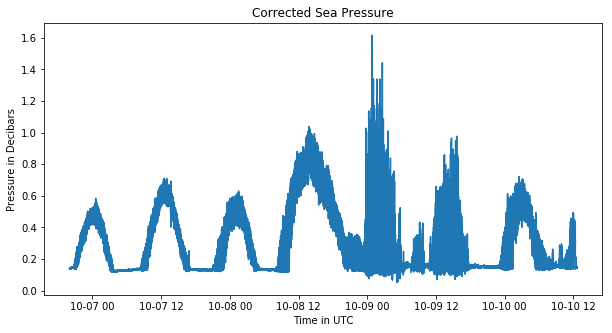

In [72]:
cor_press = plot_graph(corrected_date_times, 
           corrected_pressure, 
           'Corrected Sea Pressure', 
           'Time in UTC', 
           'Pressure in Decibars', 
           (10,5),
           'corrected_pressure')

In [73]:
from IPython.display import HTML

HTML("<img src='" + cor_press + "' />")

### Calculating Water Level

For assessing either storm surge or Storm-Tide, the choices are either Linear Wave Theory or the Hydrostatic method.   This software was developed in the context of our Storm-Tide monitoring program. The instruments that are depolyed are either pre-bracketed, on the side of piers for example, or installed ad-hoc to systematically capture the most useful data possible.  The sites are typically are not very deep in the associated water-bodies, therefore the most accurate method to use would be the Hydrostatic method.  The equation is straight-forward as follows:

$\hphantom{`}\Huge \frac{\psi}{\rho * \mu}\hphantom{`}$ <br /><br />
Where: <br />
$\hphantom{`}\psi\hphantom{`}$ = sea pressure in decibars (dbars)<br />
$\hphantom{`}\rho\hphantom{`}$ = water density in parts per a million (ppm)<br />
$\hphantom{`}\mu\hphantom{`}$ = gravity in meters per a second squared ($\hphantom{`}ms^{2}\hphantom{`}$)

There are three values for density that are relevant to our process:
<ul>
    <li>Salt Water: 1027 ppm</li>
    <li>Brackish Water: 1015 ppm</li>
    <li>Fresh Water: 1000 ppm</li>
</ul>
<br />
*In this particular example the site is comprised of salt water.

Then calculate the water level for all frequencies (As you will see there is nearly a one to one relationship between decibar and meter units):

In [74]:
from wavelab.processing.pressure_to_depth import hydrostatic_method

unfiltered_water_level = hydrostatic_method(corrected_pressure, density="salt")

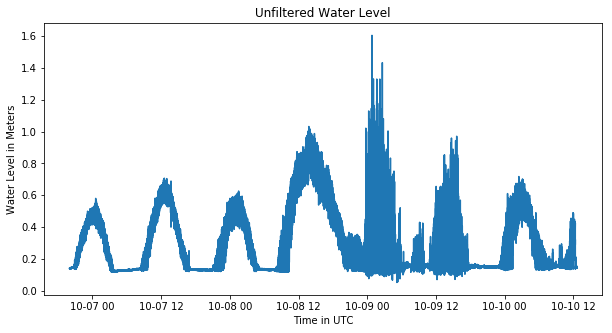

In [75]:
unfilt_wl = plot_graph(corrected_date_times, 
           unfiltered_water_level, 
           'Unfiltered Water Level', 
           'Time in UTC', 
           'Water Level in Meters', 
           (10,5),
           'unfiltered_wl')

In [76]:
from IPython.display import HTML

HTML("<img src='" + unfilt_wl + "' />")

### Choosing a Filter

USGS defines Storm-Tide as low-pass filtered signal including frequencies of both tide and storm surge.  There are many such filters to accomplish theis low-pass including USGS PL33 and Godin which use a kernel to attenuate the high frequencies.  This software euses a Butterworth filter which attenuates in frequency space.  It is desireable because of the minimized edge effects and steep decay in attenuation.  One of the parameters of the filter is an order which increases the steepness of the decay, (affecting less signal), however edge effects can occur and best judgement balancing the order must be used.  The best practice is to use an even number for the order of the filter because mathematicaly it is easier to resolve in frequncy space. After assessing performance of many orders a 4th order filter was chosen.

Other things to consider are:

- A one-minute cutoff was used in the low-pass filter, this ensured that by 30 seconds (the beginning of wind-wave frequencies), the signal was fully attenuated.
- The signal was filtered twice to preserve the phase angles (original position) of the water level time series.
- Although adequate for data with a wid reange of sampling frequencies, this filter was optimized for 4hz data (adjustments were mad to prepare for edge cases of 1 minute or more sampled data.)

### Calculating Storm-Tide

In [77]:
from wavelab.processing.pressure_to_depth import lowpass_filter

storm_tide_water_level = lowpass_filter(unfiltered_water_level, 4 #frequency in hz)

This is the longer hand version of the above:

In [81]:
from scipy import signal

# One minute cutoff divided by the Nyquist Frequency of 4hz
lowcut = .016666666665 / (.5 * 4)

# 4th order butterworth filter
b, a = signal.butter(4, [lowcut], btype='lowpass')

# Double filter to presever phase angles
storm_tide_water_level = signal.filtfilt(b, a, unfiltered_water_level)

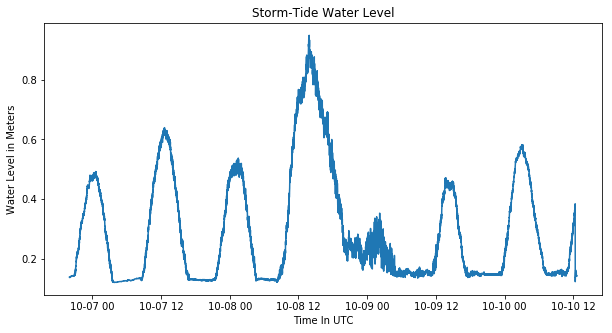

In [78]:
st_wl = plot_graph(corrected_date_times, 
           storm_tide_water_level, 
           'Storm-Tide Water Level', 
           'Time In UTC', 
           'Water Level in Meters', 
           (10,5),
            'st_wl')

In [79]:
from IPython.display import HTML

HTML("<img src='" + st_wl + "' />")

## References (filtering)

Emery, William J. and Richard E. Thomson (2014), Data Analysis Methods in Physical Oceanography, 617-619.

Hamid, S. and Alan V. Oppenheim and Alan S. Willsky (1997), Signals and Systems.

scipy.signal.butter (2014), https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.signal.butter.html

scipy.signal.buttord (2014), https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.signal.buttord.html#scipy.signal.buttord

Oliphant, Travis, scipy.signal.filtfilt (2002), https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.signal.filtfilt.html